In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
from time import time

In [2]:
mnist = input_data.read_data_sets('../datasets', one_hot = True)
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../datasets/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../datasets/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../datasets/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../datasets/t10k-labels-idx1-ubyte.gz
55000
5000
10000


In [3]:
# print(mnist.train.images[0])
print(mnist.train.images.shape)
print(mnist.train.labels[0])
print(mnist.train.labels.shape)

(55000, 784)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(55000, 10)


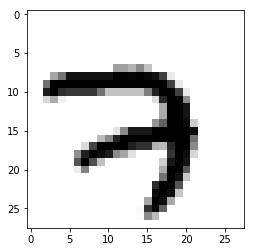

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


In [4]:
def plot_image(image):
    plt.imshow(image.reshape(28, 28), cmap = 'binary')
    plt.show()

plot_image(mnist.train.images[0])
print(mnist.train.labels[0])
print(np.argmax(mnist.train.labels[0]))

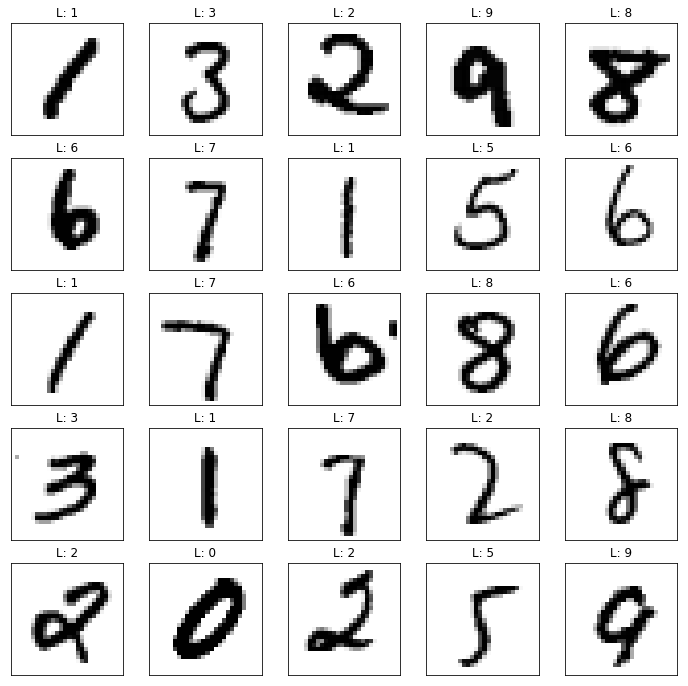

In [8]:
def plot_images_labels_prediction(images, labels, prediction, idx, num = 25):
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    if num > 25:
        num = 25
    for i in range(0, num):
        ax = plt.subplot(5, 5, i + 1)
        ax.imshow(np.reshape(images[idx], (28, 28)), cmap = 'binary')
        title = 'L: ' + str(np.argmax(labels[idx]))
        if len(prediction) > 0:
            title += ' P: ' + str(prediction[idx])
        ax.set_title(title, fontsize = 12)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()
    
plot_images_labels_prediction(mnist.train.images, mnist.train.labels, [], 0)

In [9]:
batch_images_xs, batch_labels_ys = mnist.train.next_batch(batch_size = 100)
print(len(batch_images_xs))
print(len(batch_labels_ys))

100
100


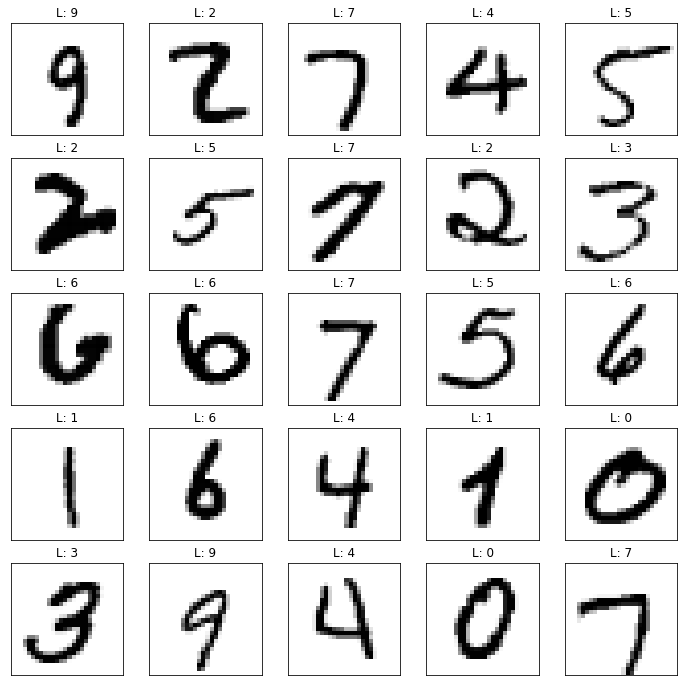

In [10]:
plot_images_labels_prediction(batch_images_xs, batch_labels_ys, [], 0)

# Model

In [12]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.1), name = 'W')

In [20]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape = shape), name = 'b')

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

In [15]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

### Input Layer

In [18]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder('float', shape = [None, 784], name = 'x')
    x_image = tf.reshape(x, [-1, 28, 28, 1])

### Convolutional Layer 1

In [22]:
with tf.name_scope('Con1_Layer'):
    W1 = weight([5, 5, 1, 16])
    b1 = bias([16])
    Conv1 = conv2d(x_image, W1) + b1
    C1_Conv = tf.nn.relu(Conv1)

### Pooling Layer 1

In [24]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

### Convolutional Layer 2

In [25]:
with tf.name_scope('Con2_Layer'):
    W2 = weight([5, 5, 16, 36])
    b2 = bias([36])
    Conv2 = conv2d(C1_Pool, W2) + b2
    C2_Conv = tf.nn.relu(Conv2)

### Pooling Layer 1

In [26]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)

### Flatten Layer

In [27]:
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_Pool, [-1, 1764])

### Hidden Layer

In [28]:
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764, 128])
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3)
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob = 0.8)

### Output Layer

In [29]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128, 10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)

# Train

In [30]:
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape = [None, 10], name = 'y_label')
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_predict, labels = y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(loss_function)

In [31]:
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1), tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [34]:
train_epochs = 30
batch_size = 100
total_batchs = int(mnist.train.num_examples / batch_size)
loss_list = []
epoch_list = []
accuracy_list = []
start_time = time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(train_epochs):
    for i in range(total_batchs):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict = {x: batch_x, y_label: batch_y})
    loss, acc = sess.run([loss_function, accuracy], feed_dict = {x: mnist.validation.images, y_label: mnist.validation.labels})
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)
    print('Train Epoch: %d Loss: %f Accuracy: %f' % ((epoch + 1), loss, acc))
duration = time() - start_time
print('Accuracy: ', sess.run(accuracy, feed_dict = {x: mnist.test.images, y_label: mnist.test.labels}))
print('Time: ', duration)

Train Epoch: 1 Loss: 1.673040 Accuracy: 0.812000
Train Epoch: 2 Loss: 1.540055 Accuracy: 0.937000
Train Epoch: 3 Loss: 1.521144 Accuracy: 0.946600
Train Epoch: 4 Loss: 1.507106 Accuracy: 0.960400
Train Epoch: 5 Loss: 1.503535 Accuracy: 0.961800
Train Epoch: 6 Loss: 1.497504 Accuracy: 0.967000
Train Epoch: 7 Loss: 1.493611 Accuracy: 0.971800
Train Epoch: 8 Loss: 1.490041 Accuracy: 0.974400
Train Epoch: 9 Loss: 1.488503 Accuracy: 0.976200
Train Epoch: 10 Loss: 1.488196 Accuracy: 0.975400
Train Epoch: 11 Loss: 1.485210 Accuracy: 0.979000
Train Epoch: 12 Loss: 1.484706 Accuracy: 0.979000
Train Epoch: 13 Loss: 1.484378 Accuracy: 0.979000
Train Epoch: 14 Loss: 1.483852 Accuracy: 0.979800
Train Epoch: 15 Loss: 1.483521 Accuracy: 0.978600
Train Epoch: 16 Loss: 1.479132 Accuracy: 0.985600
Train Epoch: 17 Loss: 1.481939 Accuracy: 0.980800
Train Epoch: 18 Loss: 1.479608 Accuracy: 0.983800
Train Epoch: 19 Loss: 1.481547 Accuracy: 0.981800
Train Epoch: 20 Loss: 1.478772 Accuracy: 0.984800
Train Epo

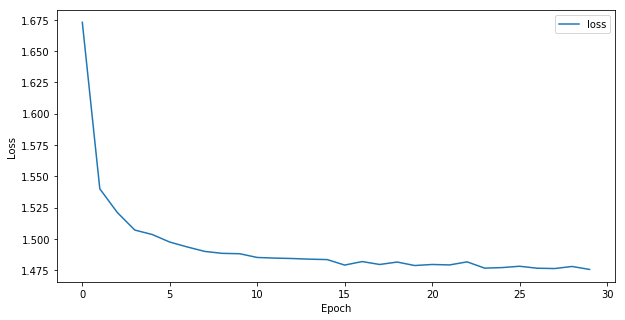

In [35]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss'])
plt.show()

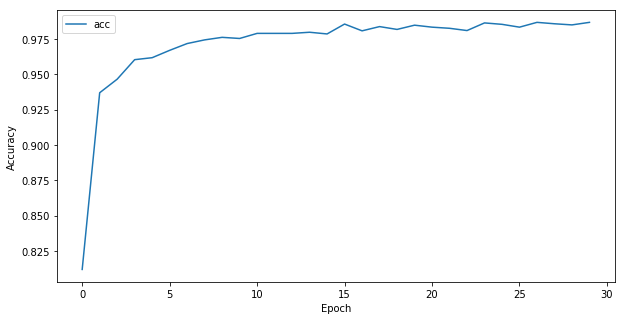

In [36]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epoch_list, accuracy_list, label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc'])
plt.show()

# Predict

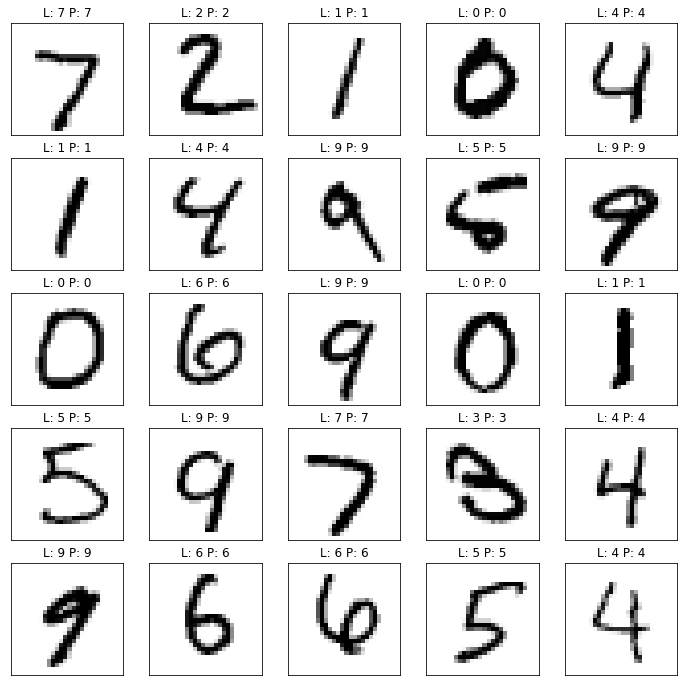

In [37]:
prediction_result = sess.run(tf.argmax(y_predict, 1), feed_dict = {x: mnist.test.images})
plot_images_labels_prediction(mnist.test.images, mnist.test.labels, prediction_result, 0)

# TensorBoard

In [39]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN', sess.graph)

tensorboard --logdir=/Users/dannyshau/code/deep_learning/mnist/tensorflow/CNN/log/CNN

http://localhost:6006/